<font size="10">Sentiment Analysis and Natural Language Processing</font>

<font size="2">Charles Rowe, ID# 006539689, WGU D213 Advanced Data Analytics, Task 2</font>

<font size="6">A1: Research Question</font>

Using the provided texts, can a highly accurate model (>95%) predict the sentiment of future text.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import string
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Embedding, Input
from tensorflow.keras.models import Sequential
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
tf.config.run_functions_eagerly(True)
pd.set_option("display.max_columns", None)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\charlesrowe\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\charlesrowe\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt_tab.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\charlesrowe\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


In [3]:
imdb_db_full = pd.read_csv('imdb_labelled.txt', sep='\t')
amazon_db_full = pd.read_csv('amazon_cells_labelled.txt', sep='\t')
yelp_db_full = pd.read_csv('yelp_labelled.txt', sep='\t')

imdb_db_full.to_csv('imdb.csv')
full_db = pd.concat((imdb_db_full,amazon_db_full,yelp_db_full), ignore_index=True)
full_db.to_csv('full_db.csv')
n_cols = full_db.shape[1]

reviews = full_db.iloc[:,0]
labels = full_db.iloc[:,1]

print(reviews)
print(labels)

0       A very, very, very slow-moving, aimless movie ...
1       Not sure who was more lost - the flat characte...
2       Attempting artiness with black & white and cle...
3            Very little music or anything to speak of.  
4       The best scene in the movie was when Gerardo i...
                              ...                        
2995    I think food should have flavor and texture an...
2996                             Appetite instantly gone.
2997    Overall I was not impressed and would not go b...
2998    The whole experience was underwhelming, and I ...
2999    Then, as if I hadn't wasted enough of my life ...
Name: review, Length: 3000, dtype: object
0       0
1       0
2       0
3       0
4       1
       ..
2995    0
2996    0
2997    0
2998    0
2999    0
Name: label, Length: 3000, dtype: int64


In [4]:
review_text = np.asarray(reviews)
print(f"There are {len(review_text)} reviews.")
review_text = review_text[~pd.isnull(review_text)]
print(f"There are {len(review_text)} reviews.")

There are 3000 reviews.
There are 3000 reviews.


In [5]:
rev_labels = np.asarray(labels)
print(f"There are {len(rev_labels)} labels.")
rev_labels = rev_labels[~pd.isnull(rev_labels)]
print(f"There are {len(rev_labels)} labels.")

There are 3000 labels.
There are 3000 labels.


In [6]:
sentence_tokens = [sent_tokenize(review.lower()) for review in review_text]
print(f'Tokenized into {len(sentence_tokens)} elements.')
sentence_tokens[0]

Tokenized into 3000 elements.


['a very, very, very slow-moving, aimless movie about a distressed, drifting young man.']

In [7]:
stops = stopwords.words('english') + list(string.punctuation) + ['...',' - ', 'ca', 'wo', "'s", "'ing","'ll", "'re"]
print(f"{len(stops)} stopwords")
stops

238 stopwords


['a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 "he'd",
 "he'll",
 'her',
 'here',
 'hers',
 'herself',
 "he's",
 'him',
 'himself',
 'his',
 'how',
 'i',
 "i'd",
 'if',
 "i'll",
 "i'm",
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it'd",
 "it'll",
 "it's",
 'its',
 'itself',
 "i've",
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'on

In [8]:
negation = ['but', 'not', "don't", "aren't", "couldn't", "doesn't", "hadn't", "hasn't", "haven't", 
                  "isn't", "shouldn't", "wouldn't"]
for word in negation:
    stops.remove(word)
print(f"{len(stops)} stopwords")
stops

226 stopwords


['a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'by',
 'can',
 'couldn',
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 'doing',
 'don',
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 'has',
 'hasn',
 'have',
 'haven',
 'having',
 'he',
 "he'd",
 "he'll",
 'her',
 'here',
 'hers',
 'herself',
 "he's",
 'him',
 'himself',
 'his',
 'how',
 'i',
 "i'd",
 'if',
 "i'll",
 "i'm",
 'in',
 'into',
 'is',
 'isn',
 'it',
 "it'd",
 "it'll",
 "it's",
 'its',
 'itself',
 "i've",
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own',
 're',
 's',
 'same',
 'shan

In [9]:
word_tokens = []

for sentences in sentence_tokens:
    temporary_list = []

    if (len(sentences)) == 1:
        words_in_sentence = word_tokenize(sentences[0])
        for word in words_in_sentence:
            if word == "n't":
                word = "not"
            temporary_list.append(word)
    else:
        num_sentences = len(sentences)

        for i in range(0, num_sentences):
            words_in_sentence = word_tokenize(sentences[i])
            for word in words_in_sentence:
                if word == "n't":
                    word = "not"
                temporary_list.append(word)

    if len(temporary_list) == 0:
        temporary_list = ['empty']

    trimmed_words = [word for word in temporary_list if word not in stops]
    word_tokens.append(trimmed_words)

In [10]:
i = 0 
bag_of_words = []
max_review_length = 0

for words in word_tokens:
    if len(words) > max_review_length:
        max_review_length = len(words)
        print(f"New maximum review length found: Index {i} contains {max_review_length} word tokens.")
    for word in words:
        bag_of_words.append(word)
    i += 1 

unique_words = set(bag_of_words)
num_uniq_words = len(unique_words)
print(f"There are {len(bag_of_words)} words in this dataset, of which {num_uniq_words} words are unique. \nThe maximum number of words in any single review is {max_review_length}.")

New maximum review length found: Index 0 contains 7 word tokens.
New maximum review length found: Index 1 contains 9 word tokens.
New maximum review length found: Index 2 contains 18 word tokens.
New maximum review length found: Index 42 contains 25 word tokens.
New maximum review length found: Index 243 contains 27 word tokens.
New maximum review length found: Index 390 contains 39 word tokens.
New maximum review length found: Index 620 contains 41 word tokens.
There are 19309 words in this dataset, of which 5206 words are unique. 
The maximum number of words in any single review is 41.


In [11]:
word_tokens[620]

['masterful',
 'piece',
 'film-making',
 'many',
 'themes',
 'simmering',
 'occasionally',
 'boiling',
 'warts',
 'study',
 'poet',
 'bohemian',
 'self-indulgent',
 'wartime',
 'years',
 'span',
 'aerial',
 'bombardments',
 'london',
 'outward',
 'tranquillity',
 'welsh',
 'coastal',
 'retreat',
 'borderlines',
 'friendship',
 'lust',
 'love',
 'dedication',
 'art',
 'experience',
 'versus',
 'practical',
 'concerns',
 'jealousy',
 'rivalry',
 'cowardice',
 'egotism',
 'versus',
 'heroism',
 'self-sacrifice']

In [12]:
row_list = []
i = 0

for i in range(0, len(word_tokens)):
    temp_dict = {}
    temp_string = ""
    for word in word_tokens[i]:
        temp_string = temp_string + word + " "
    temp_dict.update({"recommended" : rev_labels[i]})
    temp_dict.update({"review_text" : temp_string})
    row_list.append(temp_dict)
    i += 1

new_df = pd.DataFrame(row_list)
new_df

,recommended,review_text
0,0,slow-moving aimless movie distressed drifting ...
1,0,not sure lost flat characters audience nearly ...
2,0,attempting artiness black white clever camera ...
3,0,little music anything speak
4,1,best scene movie gerardo trying find song keep...
...,...,...
2995,0,think food flavor texture lacking
2996,0,appetite instantly gone
2997,0,overall not impressed would not go back
2998,0,whole experience underwhelming think go ninja ...


In [13]:
X = new_df['review_text']
y = new_df['recommended']

X_train, X_remaining, y_train, y_remaining = train_test_split(X, y, train_size=.7, random_state = 1987)
X_valid, X_test, y_valid, y_test = train_test_split(X_remaining, y_remaining, test_size=0.5, random_state = 1987) 

In [14]:
tokenizer = Tokenizer(num_words= 5000, lower= False)
tokenizer.fit_on_texts(X_train)
vocab_size = len(tokenizer.word_index) + 1
print(f"Vocab is {vocab_size} elements long.")

word_index = tokenizer.word_index
word_index


Vocab is 4095 elements long.


{'not': 1,
 'good': 2,
 'great': 3,
 'but': 4,
 'movie': 5,
 'phone': 6,
 'film': 7,
 'one': 8,
 'food': 9,
 'like': 10,
 'time': 11,
 'service': 12,
 'really': 13,
 'bad': 14,
 'well': 15,
 'would': 16,
 'place': 17,
 'could': 18,
 'best': 19,
 'ever': 20,
 'go': 21,
 'back': 22,
 'even': 23,
 'also': 24,
 'quality': 25,
 'made': 26,
 'product': 27,
 "''": 28,
 'work': 29,
 'nice': 30,
 "'m": 31,
 'love': 32,
 "'ve": 33,
 'get': 34,
 'works': 35,
 'excellent': 36,
 'recommend': 37,
 'think': 38,
 'better': 39,
 'first': 40,
 'see': 41,
 'sound': 42,
 'battery': 43,
 'got': 44,
 'never': 45,
 'still': 46,
 '10': 47,
 'much': 48,
 'way': 49,
 'acting': 50,
 'headset': 51,
 'use': 52,
 'pretty': 53,
 'say': 54,
 'worst': 55,
 'terrible': 56,
 'right': 57,
 'thing': 58,
 'price': 59,
 'make': 60,
 'amazing': 61,
 'disappointed': 62,
 'every': 63,
 'real': 64,
 'two': 65,
 'minutes': 66,
 'little': 67,
 'everything': 68,
 'many': 69,
 'look': 70,
 'money': 71,
 'nothing': 72,
 '2': 73,
 'e

In [15]:
X_train_seqs = tokenizer.texts_to_sequences(X_train)
X_train_pad = pad_sequences(X_train_seqs, maxlen=max_review_length, padding='post')
X_test_seq = tokenizer.texts_to_sequences(X_test)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_review_length, padding='post')
X_val_seq = tokenizer.texts_to_sequences(X_valid)
X_val_pad = pad_sequences(X_val_seq, maxlen=max_review_length, padding='post')

In [16]:
print(f"The shape of the padded reviews within the training set is {X_train_pad.shape}")
print(X_train_pad)

The shape of the padded reviews within the training set is (2100, 41)
[[1607  113  191 ...    0    0    0]
 [ 328 1609  693 ...    0    0    0]
 [   8  374  694 ...    0    0    0]
 ...
 [ 427  131    0 ...    0    0    0]
 [ 173  266   30 ...    0    0    0]
 [ 198  150  180 ...    0    0    0]]


In [17]:
print(f"The shape of the padded reviews within the training set is {y_train.shape}")
print(y_train)

The shape of the padded reviews within the training set is (2100,)
520     0
2152    0
2766    1
2752    1
2827    0
       ..
1606    1
746     1
1955    0
2574    1
1516    1
Name: recommended, Length: 2100, dtype: int64


In [18]:
new_df.to_csv('task2.csv')

In [19]:
model = Sequential()
model.add(Input(shape=[41]))
model.add(Embedding(input_dim= vocab_size, output_dim= 4096, input_length = max_review_length))
model.add(Dense(64, activation = "relu"))
model.add(Dense(32, activation = "relu"))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer= 'adam', loss= 'binary_crossentropy', metrics=['accuracy'])
print(model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 41, 4096)       │    16,773,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 41, 64)         │       262,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 41, 32)         │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 41, 1)          │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,037,441 (64.99 MB)

 Trainable params: 17,037,441 (64.99 MB)

 Non-trainable params: 0 (0.00 B)

None


In [20]:
num_classes = 41
y_train = to_categorical(y_train, num_classes=num_classes)
print(y_train.shape)
y_valid = to_categorical(y_valid, num_classes=num_classes)
print(y_valid.shape)
early_stop_check = EarlyStopping(monitor='val_accuracy', patience=3)
results = model.fit(X_train_pad, y_train, validation_data = (X_val_pad, y_valid), epochs=15, callbacks=early_stop_check)

(2100, 41)
(450, 41)
Epoch 1/15
66/66 ━━━━━━━━━━━━━━━━━━━━ 20s 305ms/step - accuracy: 0.9129 - loss: 0.1674 - val_accuracy: 0.9756 - val_loss: 0.0707
Epoch 2/15
66/66 ━━━━━━━━━━━━━━━━━━━━ 19s 294ms/step - accuracy: 0.9757 - loss: 0.0659 - val_accuracy: 0.9757 - val_loss: 0.0739
Epoch 3/15
66/66 ━━━━━━━━━━━━━━━━━━━━ 21s 324ms/step - accuracy: 0.9766 - loss: 0.0569 - val_accuracy: 0.9733 - val_loss: 0.0788
Epoch 4/15
66/66 ━━━━━━━━━━━━━━━━━━━━ 20s 303ms/step - accuracy: 0.9791 - loss: 0.0552 - val_accuracy: 0.9734 - val_loss: 0.0811
Epoch 5/15
66/66 ━━━━━━━━━━━━━━━━━━━━ 19s 291ms/step - accuracy: 0.9792 - loss: 0.0521 - val_accuracy: 0.9736 - val_loss: 0.0878


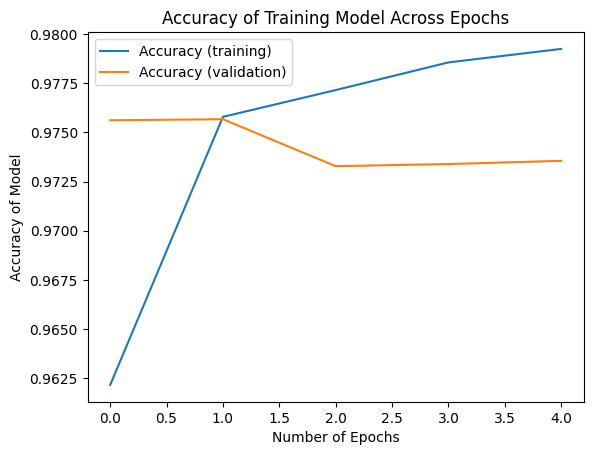

In [21]:
plt.plot(results.history['accuracy'], label= "Accuracy (training)")
plt.plot(results.history['val_accuracy'], label= "Accuracy (validation)")
plt.xlabel("Number of Epochs")
plt.ylabel("Accuracy of Model")
plt.legend()
plt.title("Accuracy of Training Model Across Epochs")
plt.show()

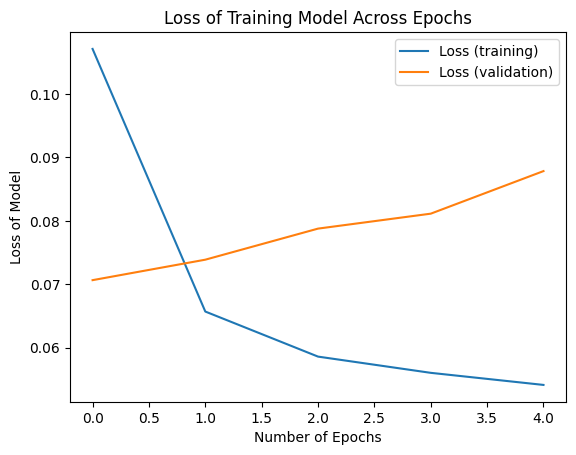

In [22]:
plt.plot(results.history['loss'], label= "Loss (training)")
plt.plot(results.history['val_loss'], label= "Loss (validation)")
plt.xlabel("Number of Epochs")
plt.ylabel("Loss of Model")
plt.legend()
plt.title("Loss of Training Model Across Epochs")
plt.show()

In [23]:
y_test = to_categorical(y_test, num_classes=num_classes)
print(y_test.shape)
model.evaluate(X_test_pad, y_test)

(450, 41)
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9734 - loss: 0.1012


[0.09885433316230774, 0.9730624556541443]

In [ ]:
#model.save('Task2Model.keras')